# CH6 SVM

* PRML
* Learning with Kernels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## MLiA

### Load Data

#### readlines

In [2]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split("\t")
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat
    

#### pandas

In [3]:
import pandas as pd
def loadDataSet(fileName):
    df = pd.read_table(fileName, header=None)
    dataMat = df[[0,1]].values
    labelMat = df[2].values
    return dataMat, labelMat

In [4]:
dataArr, labelArr = loadDataSet("./Data/CH6/testSet.txt")

#### helper function

关于clipAlpha，可以参考《统计学习方法》中的描述
$H,L$是$\alpha$取值的界

另外具体的Clipping是源于Platt的文章[2]

In [5]:
def selectJrand(i,m):
    j=i
    while (j==i):
        j = int(np.random.uniform(0,m))
    return j

def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

### SMO

#### smoSimple
C用来控制**函数间隔**以及**保证大部分点的函数间隔小于1.0**

In [6]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = np.mat(dataMatIn)             # mxn = 100x2
    labelMat = np.mat(classLabels).transpose() # mx1 = 100x1
    b = 0; m,n = np.shape(dataMatrix)          # mxn
    alphas = np.mat(np.zeros((m,1)))           # mx1 
    iter_ = 0
    while (iter_ < maxIter):
        alphaPairsChanged = 0
        # 遍历整个数据集中每个样本，要知道alpha的维度和样本的维度一样
        for i in range(m):
            # f(x) at i 
            # 对应了李航书上的g(x),这里还没有用核函数 7.104
            #1
            fXi = float(np.multiply(alphas,labelMat).T*\
                        (dataMatrix*dataMatrix[i,:].T)) + b #2
                        # [1]
                        # a * y * x * xi + b 
                        # multiply(mx1,mx1).T = multipy(100x1,100x1).T = (100x1).T = (1x100)
                        #[2]
                        # (mxn)x(1xn).T = (100x2)x(1x2).T = (100x2)x(2x1) = (100x1)
            # 7.105
            Ei = fXi - float(labelMat[i])
            # 对应了两边的边界情况            
            if ((labelMat[i]*Ei < - toler) and (alphas[i] < C)) or \
               ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                    # f(x) at j
                    j = selectJrand(i,m)
                    # 到这里i,j都定了
                    fXj = float(np.multiply(alphas,labelMat).T*\
                                (dataMatrix*dataMatrix[j,:].T)) + b
                    Ej = fXj - float(labelMat[j])
                    
                    alphaIold = alphas[i].copy()
                    alphaJold = alphas[j].copy()
                    
                    if (labelMat[i] != labelMat[j]):
                        L = max(0, alphas[j] - alphas[i])
                        H = min(C, C + alphas[j] - alphas[i])
                    else:
                        L = max(0, alphas[j] + alphas[i] - C)
                        H = min(C, alphas[j] + alphas[i])
                    if L==H: 
                        print("L==H")
                        continue
                    
                    # 1x2 x (1x2).T = 1x2x2x1
                    # alpha 最优修改量 = xj^2 - xi^2 - 2xixj = (xj - xi)^2 - 2xi^2
                    # 7.107
                    eta = 2*dataMatrix[i,:]*dataMatrix[j,:].T-\
                          dataMatrix[i,:]*dataMatrix[i,:].T-\
                          dataMatrix[j,:]*dataMatrix[j,:].T
                    # 简化处理
                    if eta >= 0:
                        print("eta>=0")
                        continue
                    # alphas[j]
                    alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                    alphas[j] = clipAlpha(alphas[j],H,L)
                    
                    if (abs(alphas[j] - alphaJold) < 0.00001):
                        print("j not moving enough")
                        continue
                    # alphas[i]
                    alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                    # 
                    b1 = b - Ei - labelMat[i]*(alphas[i] - alphaIold)*\
                         dataMatrix[i,:]*dataMatrix[i,:].T - \
                         labelMat[j]*(alphas[j]-alphaJold)*\
                         dataMatrix[i,:]*dataMatrix[j,:].T
                    
                    b2 = b - Ej - labelMat[i]*(alphas[i]-alphaIold)*\
                         dataMatrix[i,:]*dataMatrix[j,:].T -\
                         labelMat[j]*(alphas[j]-alphaJold)*\
                         dataMatrix[j,:]*dataMatrix[j,:].T
                    
                    if (0 < alphas[i]) and (C > alphas[j]):
                        b = b1
                    elif (0 < alphas[j]) and (C > alphas[j]):
                        b = b2
                    else:
                        b = (b1 + b2)/2
                    alphaPairsChanged += 1
                    print("iter: %d i: %d, paris changed %d" % (iter_, i, alphaPairsChanged))
        if (alphaPairsChanged == 0):
            iter_ += 1
        else:
            iter_ = 0
        print("iteration number: %d" % iter_)
    return b, alphas

In [7]:
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

iter: 0 i: 0, paris changed 1
j not moving enough
iter: 0 i: 5, paris changed 2
j not moving enough
j not moving enough
L==H
iter: 0 i: 25, paris changed 3
L==H
L==H
j not moving enough
iter: 0 i: 34, paris changed 4
iter: 0 i: 39, paris changed 5
L==H
j not moving enough
iter: 0 i: 54, paris changed 6
iter: 0 i: 55, paris changed 7
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
iteration number: 0
j not moving enough
L==H
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
iter: 0 i: 21, paris changed 1
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i: 53, paris changed 2
j not moving enough
iter: 0 i: 55, paris changed 3
iter: 0 i: 62, paris change

L==H
j not moving enough
j not moving enough
iter: 0 i: 77, paris changed 1
j not moving enough
L==H
iteration number: 0
L==H
iter: 0 i: 8, paris changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i: 54, paris changed 1
j not moving enough
iteration number: 0
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j n

L==H
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
L==H
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 10
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numb

iteration number: 33
j not moving enough
j not moving enough
iteration number: 34
j not moving enough
j not moving enough
iteration number: 35
j not moving enough
j not moving enough
iteration number: 36
j not moving enough
j not moving enough
iteration number: 37
j not moving enough
j not moving enough
iteration number: 38
j not moving enough
j not moving enough
iteration number: 39
j not moving enough
j not moving enough
iteration number: 40


##### 拉格朗日乘子

In [8]:
alpha = alphas[alphas > 0]
alpha

matrix([[0.11448958, 0.24978708, 0.00919759, 0.35507907]])

##### 支持向量
$\alpha > 0$的对应支持向量， 注意支持向量可能在边界，可能在边界中，也可能错分一侧

In [9]:
for i in range(100):
    if alphas[i] > 0:
        print(dataArr[i],labelArr[i])      

[4.658191 3.507396] -1
[ 3.457096 -0.082216] -1
[ 5.286862 -2.358286] 1
[6.080573 0.418886] 1


In [10]:
result = 0
for i in range(100):
    if alphas[i] > 0:
        result += labelArr[i]*alphas[i]
        print(dataArr[i],labelArr[i])
print(result) # sum(alpha*y) = 0

[4.658191 3.507396] -1
[ 3.457096 -0.082216] -1
[ 5.286862 -2.358286] 1
[6.080573 0.418886] 1
[[5.55111512e-17]]


##### 超平面

In [11]:
df = pd.read_table("./Data/CH6/testSet.txt", header=None)
df.columns = ["x0","x1","y"]
df.head()

,x0,x1,y
0,3.542485,1.977398,-1
1,3.018896,2.556416,-1
2,7.551510,-1.580030,1
3,2.114999,-0.004466,-1
4,8.127113,1.274372,1


In [12]:
df.describe()

,x0,x1,y
count,100.000000,100.000000,100.000000
mean,4.790926,0.059057,-0.080000
std,3.103636,1.465117,1.001817
min,-0.743036,-5.766721,-1.000000
25%,1.976116,-0.573050,-1.000000
50%,3.539520,-0.009497,-1.000000
75%,8.034324,0.810767,1.000000
max,9.854303,3.964960,1.000000


In [13]:
def calcWs(alphas, dataArr, classLabels):
    X = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

In [14]:
HP_ws = calcWs(alphas, dataArr, labelArr).reshape(2,).tolist()
HP_b = b.tolist()[0]
HP_x = [-2,12]
HP_y_L = [-HP_ws[0]*x/HP_ws[1] - (HP_b[0]+1)/HP_ws[1] for x in HP_x]
HP_y_H = [-HP_ws[0]*x/HP_ws[1] - (HP_b[0]-1)/HP_ws[1] for x in HP_x]
HP_y = [-HP_ws[0]*x/HP_ws[1] - (HP_b[0]+0)/HP_ws[1] for x in HP_x]

print(HP_ws,HP_b)
print(HP_x,HP_y)
# HP_y -> x1, HP_x -> x0

[0.8108583535261407, -0.2539767167836068] [-3.8240961202888877]
[-2, 12] [-21.442173504357527, 23.254903822766572]


##### Visualization
这是个线性可分的数据集

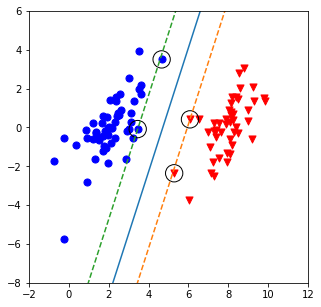

In [15]:
# sns.pointplot(x=0,y=1,data=df,hue=2,linestyles="-")
# sns.pairplot(data=df,vars = [0,1],hue=2)
# g = sns.jointplot(x=0,y=1,data=df,kind="kde")
# g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")

%matplotlib inline
plt.figure(figsize = (5,5))

supportVactor = df[list(map(lambda x:x[0]>0,alphas.tolist()))]
plt.scatter(x=df[df["y"] == 1]["x0"],y=df[df["y"] == 1]["x1"],
            s = 50, marker = "v",c="red")
plt.scatter(x=df[df["y"] == -1]["x0"],y=df[df["y"] == -1]["x1"],
            s = 50, c="blue")
plt.scatter(x=supportVactor["x0"],y=supportVactor["x1"],
            s = 300, marker="o",c = "none",edgecolors="black")

plt.plot(HP_x,HP_y)
plt.plot(HP_x,HP_y_H,"--")
plt.plot(HP_x,HP_y_L,"--")
plt.xlim(-2,12)
plt.ylim(-8,6)
plt.show()

### smoP

#### 支持向量求解

#### w求解

#### 可视化

### 核函数

### 实例

#### Mnist

## Sklearn

### Load Data

In [16]:
import pandas as pd
def loadDataSet(fileName):
    df = pd.read_table(fileName, header=None)
    dataMat = df[[0,1]].values
    labelMat = df[2].values
    return dataMat, labelMat

In [17]:
dataMat, labelMat = loadDataSet(fileName="./Data/CH6/testSet.txt")

### Modeling

In [18]:
from sklearn.svm import SVC
clf = SVC(kernel="linear")
# default rbf kernel

In [19]:
X = dataMat
y = labelMat
clf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
clf.n_support_

array([2, 1], dtype=int32)

In [21]:
clf.support_

array([17, 29, 55], dtype=int32)

In [22]:
clf.support_vectors_

array([[ 4.658191,  3.507396],
       [ 3.457096, -0.082216],
       [ 6.080573,  0.418886]])

### Visualization

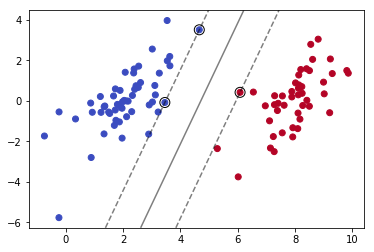

In [23]:
# plt.scatter(X[np.where(y ==1)][:,0],X[np.where(y ==1)][:,1])
# plt.scatter(X[np.where(y ==-1)][:,0],X[np.where(y ==-1)][:,1])
X0,X1 = X[:,0],X[:,1]
plt.scatter(X0,X1,c=y,cmap=plt.cm.coolwarm)
plt.scatter(clf.support_vectors_[:,0],clf.support_vectors_[:,1],marker="o",s=100,edgecolors="black",c="")

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.show()

### Comprasion

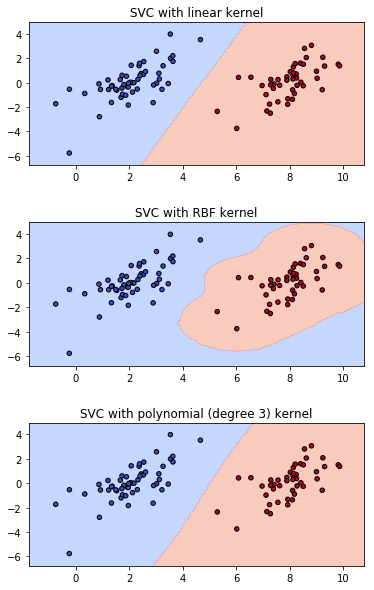

In [24]:
C = 1
models = [SVC(kernel="linear",C=C),
          SVC(kernel="rbf",gamma=0.7,C=C),
          SVC(kernel="poly",degree=3,C=C)]
models = [clf.fit(X,y) for clf in models]
# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

fig, sub = plt.subplots(3, 1)
fig.set_figheight(10)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
X0, X1 = X[:, 0], X[:, 1]
h = 0.1
x_min, x_max = X0.min() - 1, X0.max() + 1
y_min, y_max = X1.min() - 1, X1.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xy = np.c_[xx.ravel(), yy.ravel()]

Z = (clf.predict(xy).reshape(xx.shape) for clf in models)

for clf, title, ax, z in zip(models, titles, sub.flatten(),Z):
    ax.contourf(xx, yy, z, levels=[-1, 0, 1], alpha=0.5,cmap=plt.cm.coolwarm)
    ax.scatter(X0,X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)

plt.show()

### EX1 : RBF Test

In [25]:
RBFTestData = pd.read_table("./Data/CH6/testSetRBF.txt",header=None)
RBFTestData.head()

,0,1,2
0,-0.214824,0.662756,-1.0
1,-0.061569,-0.091875,1.0
2,0.406933,0.648055,-1.0
3,0.223650,0.130142,1.0
4,0.231317,0.766906,-1.0


In [26]:
X = RBFTestData[RBFTestData.columns.tolist()[:-1]].values
y = RBFTestData[RBFTestData.columns.tolist()[-1]].values

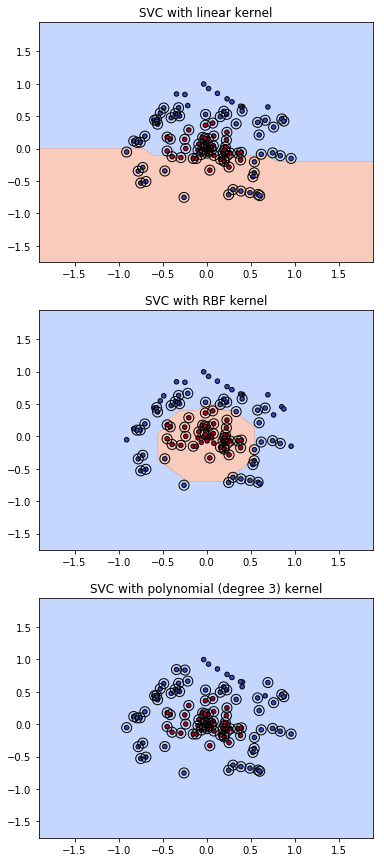

In [27]:
C = 1
models = [SVC(kernel="linear",C=C),
          SVC(kernel="rbf",gamma=0.4,C=C),
          SVC(kernel="poly",degree=3,C=C)]
models = [clf.fit(X,y) for clf in models]
# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']
fig.clf()
fig, sub = plt.subplots(3, 1)
fig.set_figheight(15)
X0, X1 = X[:, 0], X[:, 1]
h = 0.1
x_min, x_max = X0.min() - 1, X0.max() + 1
y_min, y_max = X1.min() - 1, X1.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xy = np.c_[xx.ravel(), yy.ravel()]

Z = (clf.predict(xy).reshape(xx.shape) for clf in models)

for clf, title, ax, z in zip(models, titles, sub.flatten(),Z):
    ax.contourf(xx, yy, z, levels=[-1, 0, 1], alpha=0.5,cmap=plt.cm.coolwarm)
    ax.scatter(X0,X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.scatter(clf.support_vectors_[:,0],clf.support_vectors_[:,1],c="",edgecolors="black",s=100)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
plt.show()

### EX2 : MNIST

#### Load Data

In [28]:
import glob,os
from sklearn.model_selection import train_test_split

In [29]:
def loadImage(files):
    lst = glob.glob(files)
    samples = []
    labels = []
    for filepath in lst:
        num = pd.read_csv(filepath,header=None).values
        fpath,fname = os.path.split(filepath)
        labels.append(int(fname.split("_")[0]))
        samples.append([int(x) for x in "".join([x[0] for x in num])])
    return samples, labels

In [30]:
X,y = loadImage("./Data/CH2/digits/trainingDigits/*.txt")

In [31]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1,stratify=y)

#### Modeling

In [32]:
clf = SVC(kernel="rbf",C=200,tol=0.0001)
clf.fit(X_train, y_train)

SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.0001, verbose=False)

In [33]:
y_pred = clf.predict(X_test)

In [34]:
np.mean(y_pred == y_test)

0.9845360824742269

## Ref


1. [Decision Function](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py)
1. [Fast training of support vector machines using sequential minimal optimization](http://www.cs.utsa.edu/~bylander/cs6243/smo-book.pdf)